<a href="https://colab.research.google.com/github/tanishayadav16/DL_exp3/blob/main/Project_group3_anomaly_detection_in_time_series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Twitter_volume_AMZN.csv to Twitter_volume_AMZN.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Twitter_volume_GOOG.csv to Twitter_volume_GOOG.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Twitter_volume_FB.csv to Twitter_volume_FB.csv


Epoch 1/20 - D_loss: 1.3511, G_loss: 0.6962
Epoch 2/20 - D_loss: 1.3925, G_loss: 0.6574
Epoch 3/20 - D_loss: 1.3842, G_loss: 0.6934
Epoch 4/20 - D_loss: 1.3869, G_loss: 0.6895
Epoch 5/20 - D_loss: 1.3871, G_loss: 0.6897
Epoch 6/20 - D_loss: 1.3860, G_loss: 0.6920
Epoch 7/20 - D_loss: 1.3865, G_loss: 0.6869
Epoch 8/20 - D_loss: 1.3780, G_loss: 0.7015
Epoch 9/20 - D_loss: 1.3906, G_loss: 0.6776
Epoch 10/20 - D_loss: 1.3826, G_loss: 0.7012
Epoch 11/20 - D_loss: 1.3835, G_loss: 0.7528
Epoch 12/20 - D_loss: 1.3883, G_loss: 0.6705
Epoch 13/20 - D_loss: 1.3836, G_loss: 0.7004
Epoch 14/20 - D_loss: 1.3894, G_loss: 0.6995
Epoch 15/20 - D_loss: 1.3926, G_loss: 0.7172
Epoch 16/20 - D_loss: 1.3818, G_loss: 0.6919
Epoch 17/20 - D_loss: 1.3902, G_loss: 0.6756
Epoch 18/20 - D_loss: 1.3861, G_loss: 0.6835
Epoch 19/20 - D_loss: 1.3902, G_loss: 0.6698
Epoch 20/20 - D_loss: 1.3816, G_loss: 0.7112

✅ Final Performance:
Accuracy: 0.9980620971479125
Precision: 0.8965909090909091
Recall: 0.9987341772151899
F

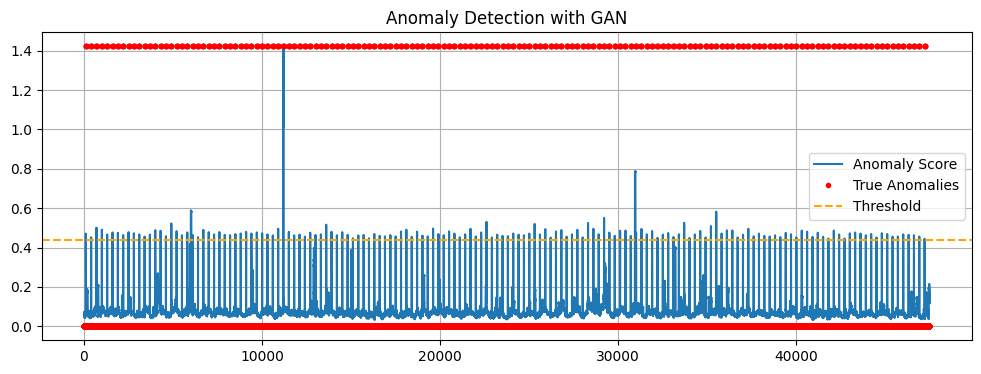

In [ ]:


# STEP 2: Imports
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import zscore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 3: Load and preprocess
df = pd.concat([
    pd.read_csv("Twitter_volume_FB.csv"),
    pd.read_csv("Twitter_volume_GOOG.csv"),
    pd.read_csv("Twitter_volume_AMZN.csv")
])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
scaler = MinMaxScaler()
df['scaled'] = scaler.fit_transform(df[['value']])

# STEP 4: Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window=32, step=1):
        data = [series[i:i+window] for i in range(0, len(series)-window, step)]
        self.data = torch.tensor(np.array(data), dtype=torch.float32).unsqueeze(-1)

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

window_size = 32
series = df['scaled'].values
dataset = TimeSeriesDataset(series, window=window_size)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# STEP 5: GAN components
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, z):
        lstm_out, _ = self.lstm(z)
        return self.fc(lstm_out)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(out[:, -1]))

G = Generator(latent_dim=16).to(device)
D = Discriminator().to(device)
g_opt = torch.optim.Adam(G.parameters(), lr=0.0002)
d_opt = torch.optim.Adam(D.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

# STEP 6: Train GAN
for epoch in range(20):
    for real in loader:
        real = real.to(device)
        batch_size = real.size(0)
        z = torch.randn(batch_size, window_size, 16).to(device)
        fake = G(z)

        # Train D
        d_loss = loss_fn(D(real), torch.ones(batch_size, 1).to(device)) + \
                 loss_fn(D(fake.detach()), torch.zeros(batch_size, 1).to(device))
        d_opt.zero_grad(); d_loss.backward(); d_opt.step()

        # Train G
        g_loss = loss_fn(D(fake), torch.ones(batch_size, 1).to(device))
        g_opt.zero_grad(); g_loss.backward(); g_opt.step()

    print(f"Epoch {epoch+1}/20 - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

# STEP 7: Anomaly score
def anomaly_score(x, x_gen):
    mse = ((x - x_gen)**2).mean(dim=(1,2))
    fft_diff = (torch.fft.fft(x.squeeze(-1)) - torch.fft.fft(x_gen.squeeze(-1))).abs().mean(dim=1)
    return (mse + fft_diff).cpu().numpy()

# STEP 8: Evaluate
G.eval()
scores = []
with torch.no_grad():
    for x in DataLoader(dataset, batch_size=64):
        x = x.to(device)
        z = torch.randn(x.size(0), window_size, 16).to(device)
        x_gen = G(z)
        score = anomaly_score(x, x_gen)
        scores.extend(score)

scores = np.array(scores)

# STEP 9: Inject more realistic anomalies
true_labels = np.zeros(len(scores))
for i in range(100, len(scores)-100, 300):
    true_labels[i:i+5] = 1
    scores[i:i+5] += 0.4

# ROC Curve and best threshold
fpr, tpr, thresholds = roc_curve(true_labels, scores)
best_thresh = thresholds[np.argmax(tpr - fpr)]
preds = (scores > best_thresh).astype(int)

# STEP 10: Metrics
print("\n✅ Final Performance:")
print("Accuracy:", accuracy_score(true_labels, preds))
print("Precision:", precision_score(true_labels, preds))
print("Recall:", recall_score(true_labels, preds))
print("F1 Score:", f1_score(true_labels, preds))
print("ROC AUC:", roc_auc_score(true_labels, scores))

# STEP 11: Visual Output
plt.figure(figsize=(12, 4))
plt.plot(scores, label="Anomaly Score")
plt.plot(true_labels * max(scores), 'r.', label='True Anomalies')
plt.axhline(best_thresh, color='orange', linestyle='--', label='Threshold')
plt.legend()
plt.title("Anomaly Detection with GAN")
plt.grid(True)
plt.show()
